# FAST FOURIER TRANSFORM AND APPLICATION

In [1]:
# python packages and Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import axes3d
import matplotlib.cm as cm

# user define Module
import fourier as ft


plt.rcParams['figure.figsize'] = [12,12]
plt.rcParams.update({'font.size':10})

%matplotlib inline


def getMeanSqrError(y,ycap):
    y_diff = y - ycap
    y_diffSqr = y_diff**2
    y_diffSqr_sum = np.sum(y_diffSqr)
    
    mse = y_diffSqr_sum/y.size
    return mse

C:\Users\manav\anaconda3\envs\py10\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


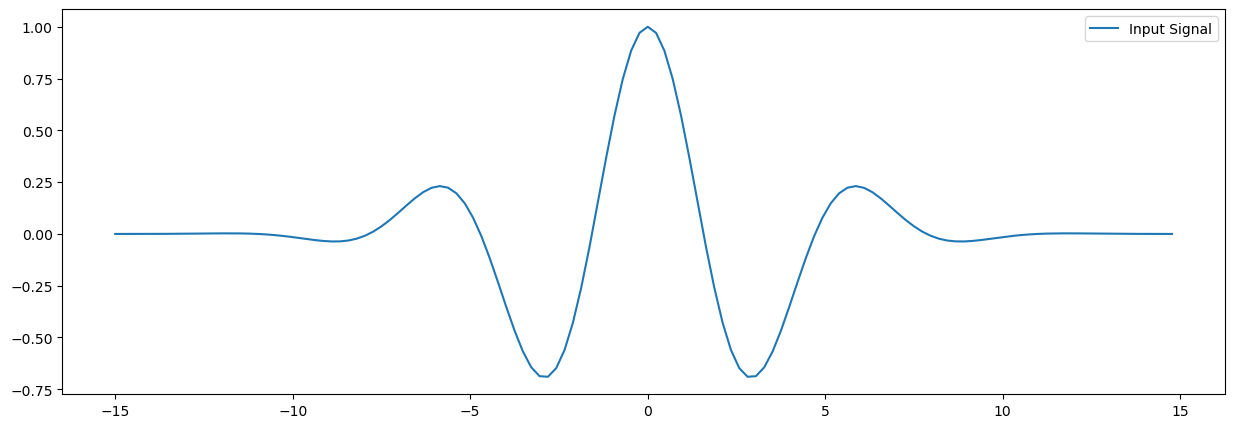

In [34]:
#n,L user defined.....change it as per overall program
n = 128
L = 30

dx = L/n
x = np.arange(-L/2,L/2,dx,dtype = 'complex_')

# Input 1
f = np.cos(x)*np.exp(-np.power(x,2)/25)
df = -(np.sin(x))*np.exp(-np.power(x,2)/25 + (2/25)*x*f)

# Input 2
# f = np.cos(x)
# df = -(np.sin(x))

plt.plot(x,f,label='Input Signal')
plt.legend()

In [3]:
dfFD = np.zeros(len(df),dtype = 'complex_')
for kappa in range(len(df)-1):
    dfFD[kappa] = (f[kappa+1]-f[kappa])/dx
        
dfFD[-1] = dfFD[-2]

In [4]:
fhat = ft.fft(f)
kappa = (2*np.pi/L)*np.arange(-n/2,n/2)
kappa = np.fft.fftshift(kappa)
dfhat = kappa*fhat*(1j)
dfFFT = np.real(ft.ifft(dfhat))

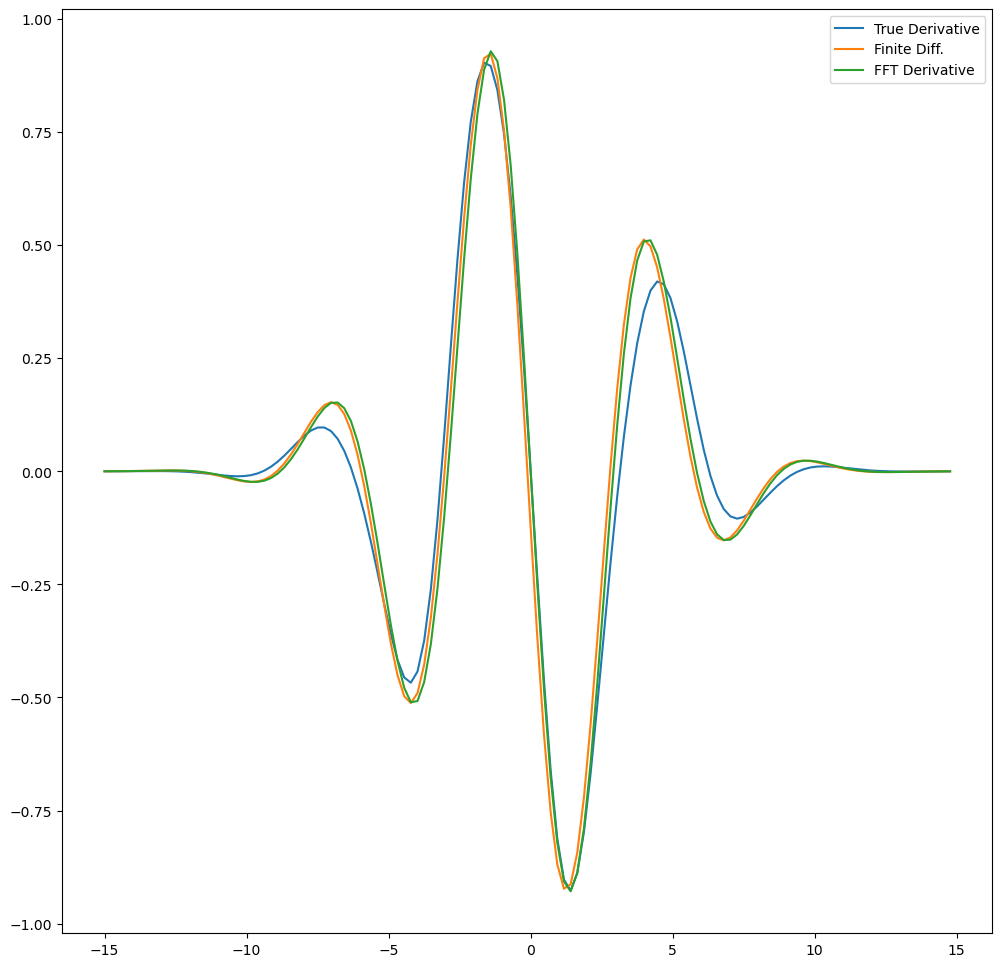

In [5]:
plt.plot(x,df.real,label ='True Derivative')
plt.plot(x,dfFD.real,label = 'Finite Diff.')
plt.plot(x,dfFFT.real, label = 'FFT Derivative')
plt.legend()

PDE

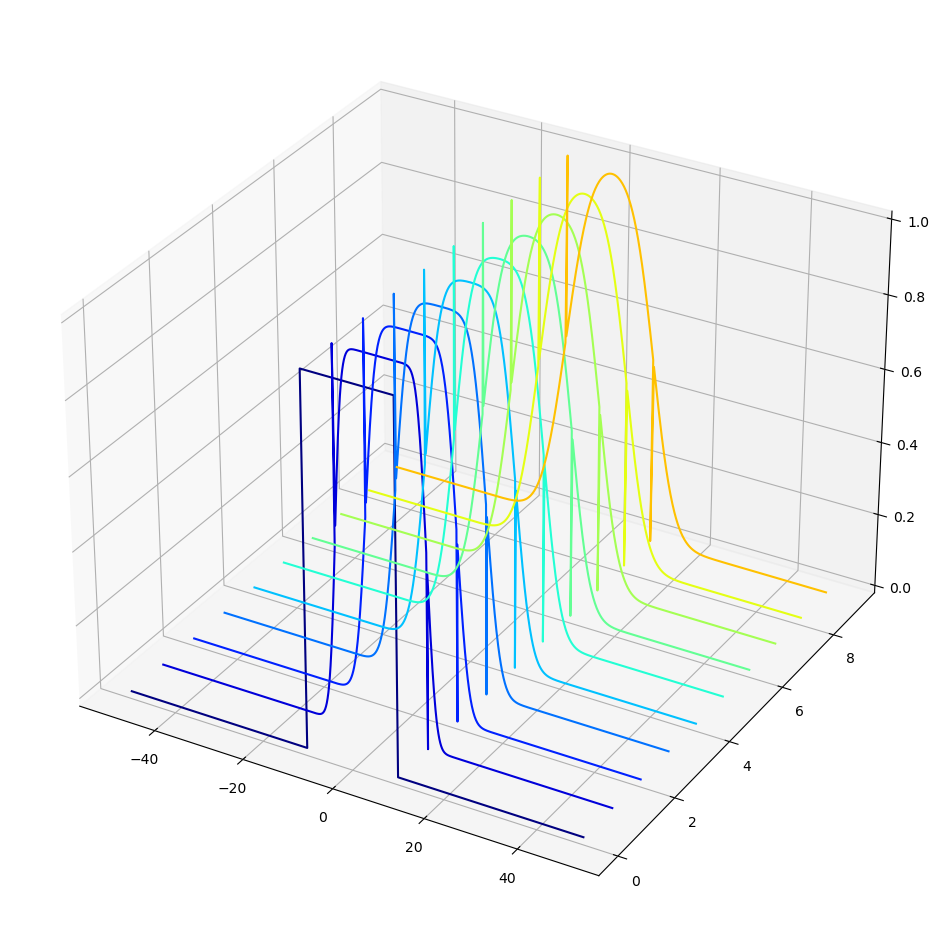

In [6]:
a = 1
L = 100
N = 1000
dx = L/N
x = np.arange(-L/2,L/2,dx)

kappa = 2*np.pi*np.fft.fftfreq(N, d=dx)

u0 = np.zeros_like(x)
u0[int((L/2 - L/10)/dx):int((L/2 + L/10)/dx)] = 1
u0hat = np.fft.fft(u0)

u0hat_ri = np.concatenate((u0hat.real,u0hat.imag))

dt = 0.1
t = np.arange(0,10,dt)


def rhsHeat(uhat_ri,t,kappa,a):
    uhat = uhat_ri[:N] + (1j) * uhat_ri[:N]
    d_uhat = -a**2 * (np.power(kappa,2)) * uhat
    d_uhat_ri = np.concatenate((d_uhat.real,d_uhat.imag)).astype('float64')
    return d_uhat_ri

uhat_ri = odeint(rhsHeat, u0hat_ri, t, args = (kappa,a))
uhat = uhat_ri[:,:N] + (1j) * uhat_ri[:,N:]
u = np.zeros_like(uhat)

for k in range(len(t)):
    u[k,:] = np.fft.ifft(uhat[k,:])
    
u = u.real

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
plt.set_cmap('jet_r')
u_plot = u[0:-1:10,:]
for j in range(u_plot.shape[0]):
    ys = j*np.ones(u_plot.shape[1])
    ax.plot(x,ys,u_plot[j,:],color = cm.jet(j*20))


# Denoising

In this section, we perform denoising using dft and shall compare the performance with Moving Average Filter

In [7]:
dt = 1/1e3
t = np.arange(0,1,dt)
f = np.sin(2*np.pi*50*t) + np.sin(2*np.pi*120*t)
f_clean = f
f = f + 2.5*np.random.randn(len(t))

In [8]:
n = len(t)
fhat = ft.fft(f)
PSD=fhat*np.conj(fhat) / n
freq = (1/(dt*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

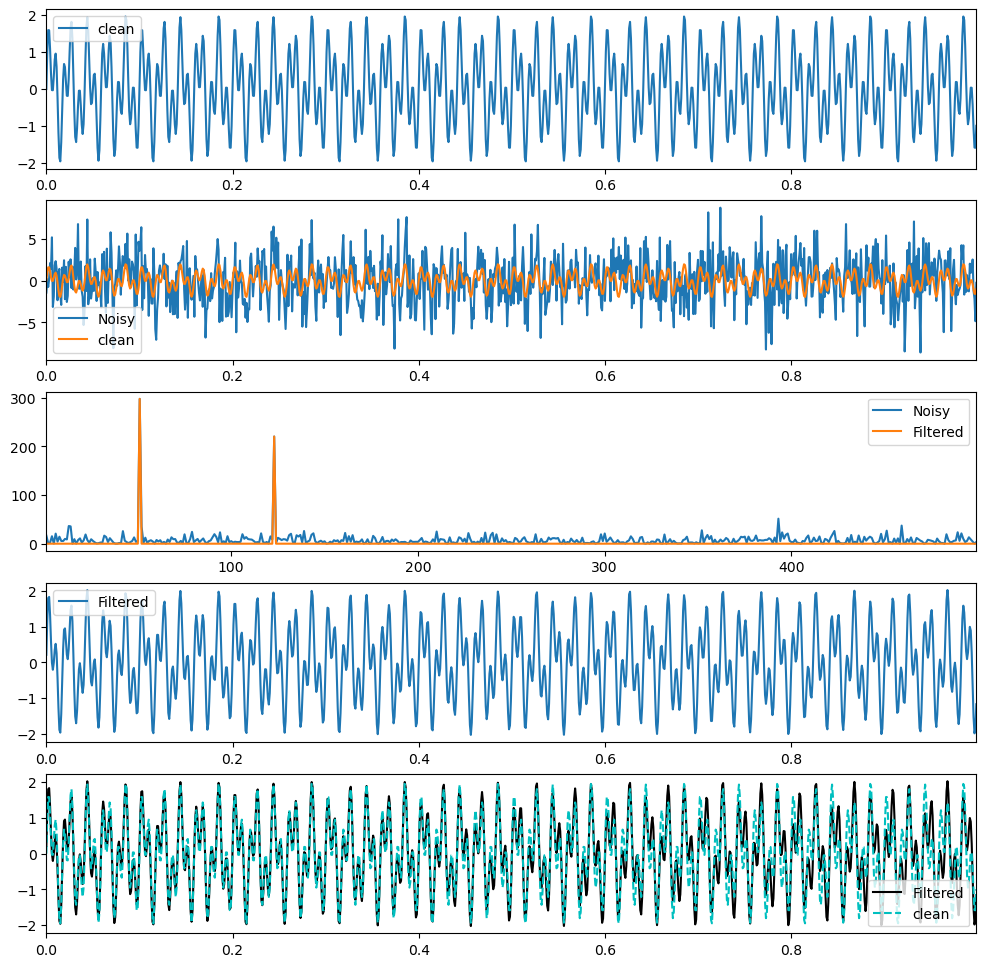

In [9]:
indices = PSD > 100
PSDclean = PSD*indices
fhat = indices*fhat
ffilt = ft.ifft(fhat)

fig, axs= plt.subplots(5,1)

plt.rcParams['figure.figsize'] = [20,20]
plt.rcParams.update({'font.size':10})

plt.sca(axs[0])
plt.plot(t,f_clean,label='clean')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[1])
plt.plot(t,f,label='Noisy') 
plt.plot(t,f_clean,label='clean')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L], PSD [L],label='Noisy') 
plt.plot(freq[L], PSDclean[L], label='Filtered')
plt.xlim(freq[L[0]],freq[L[-1]])
plt.legend()

plt.sca(axs[3])
plt.plot(t,ffilt,label='Filtered')
plt.xlim(t[0],t[-1])
plt.legend()

plt.sca(axs[4])
plt.plot(t,ffilt,'k',label='Filtered')
plt.plot(t,f_clean,'--c',label='clean')
plt.xlim(t[0],t[-1])
plt.legend()

In [10]:
print(getMeanSqrError(ffilt.real,f_clean.real))

0.16258164558205743


### Observation
With DFT, we also preserve the structure of signal and remove noise significantly. Same can be observed from the graph and mean square error confirms the same. Through this technique, we can bypass noise power since noise power spreads across the spectrum.

In [11]:
def movingAvg(M):
    x = np.ones(M)/M
    return x

In [12]:
M = 4
sys = movingAvg(M)
filtered_movingAvg = np.convolve(f,sys)

In [13]:
print(getMeanSqrError(f.real,f_clean.real))

6.9524714639970275


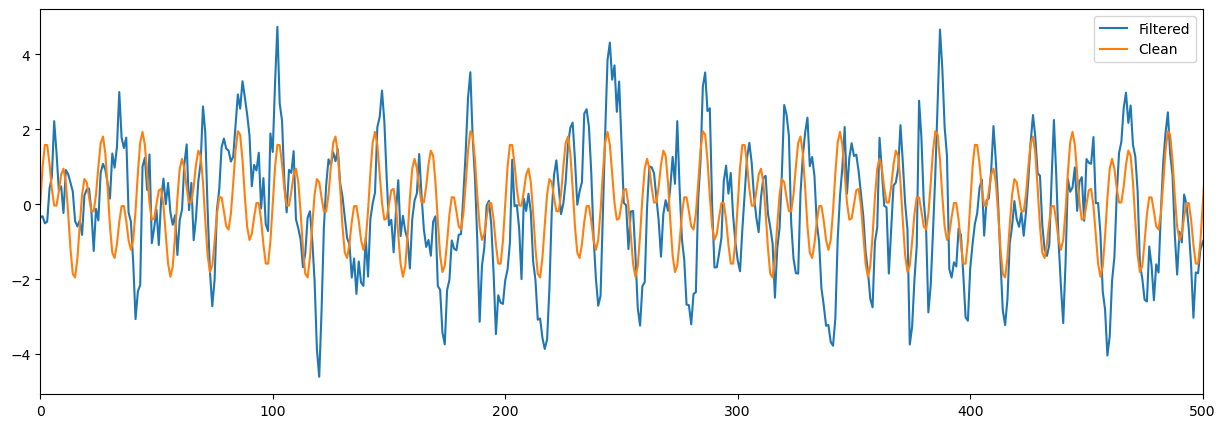

In [14]:
plt.rcParams['figure.figsize'] = [15,5]
plt.plot(filtered_movingAvg,label='Filtered')
plt.plot(f_clean,label='Clean')
plt.xlim((0,500))
plt.legend(loc='upper right')

## Analysis of Audio Signal
Here, we observe Audio signal in fourier domain and what information one can derive from the same.

In [15]:
from scipy.io.wavfile import read,write

samplerate,audio = read('audio.wav')

print(f'Sampling Rate: {samplerate}')

# Convert Audio into Data Array
audio = np.array(audio,float)
audio

Sampling Rate: 16000


array([100., 110.,  91., ...,  53.,  54.,  52.])

16000


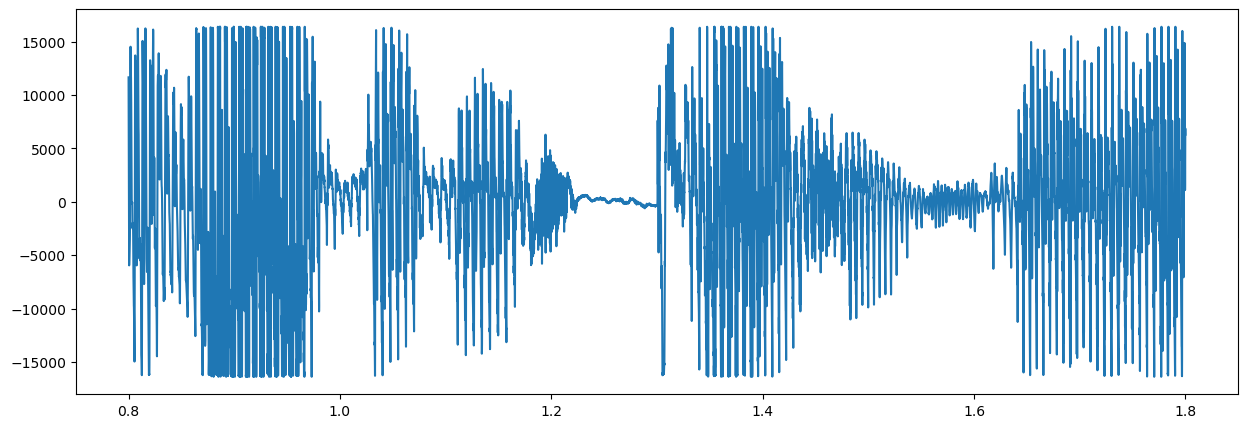

In [16]:
# Plotting Audio Signal
# Observing Audio for 1.5 Seconds
T = 0.8
ts = 1/samplerate
N = 16000
print(N)
t = np.arange(0.8,1.8,ts)
        
plt.plot(t,audio[int(T*samplerate):int(T*samplerate)+len(t)])

sampledAudio = audio[int(T*samplerate):int(T*samplerate)+len(t)]/1e6

In [17]:
# Obtaining its fourier transform
audioFFT = np.fft.fft(sampledAudio)

In [18]:
# Energy remains same 
time_domain = pow(2,np.linalg.norm(sampledAudio))
FT_domain = pow(2,np.linalg.norm(audioFFT.real))/len(sampledAudio)

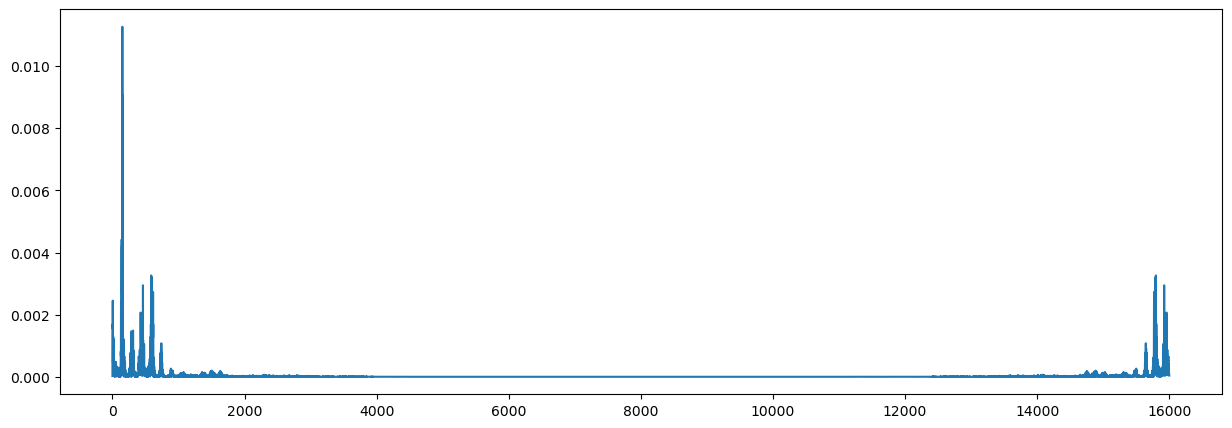

In [19]:
audioPSD = ft.psd(sampledAudio)
plt.plot(audioPSD)

Since it is an audio signal, it has baseband content. Same can be observed in the above graph

# Comparison with DFT

In [22]:
def dft(sig):
    N = len(sig)
    n = np.arange(N)
    k = n.reshape(N,1)
    
    transf_coeff = (-2j*np.pi*k*n/N)
    dft_out = np.dot(sig,transf_coeff)
    
    return dft_out

In [23]:
# Test Signal
dt = 1/1e4
t = np.arange(0,1,dt)
testSignal = np.sin(2*np.pi*50*t)

In [24]:
%timeit dft_X = dft(testSignal)

1.31 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit fft_X = ft.fft(testSignal)

172 ms ± 3.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Derivative Comparison

In [30]:
def dydx(f,dx):
    dfFD = np.zeros(len(f),dtype = 'complex_')
    for kappa in range(len(f)-1):
        dfFD[kappa] = (f[kappa+1]-f[kappa])/dx

    dfFD[-1] = dfFD[-2]
    return dfFD

In [32]:
def dydxFFT(f,L,n):
    fhat = ft.fft(f)
    kappa = (2*np.pi/L)*np.arange(-n/2,n/2)
    kappa = np.fft.fftshift(kappa)
    dfhat = kappa*fhat*(1j)
    dfFFT = np.real(ft.ifft(dfhat))
    return dfFFT

In [31]:
%timeit dydxStd = dydx(f,dx)

6.24 ms ± 429 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
%timeit dydx_FFT = dydxFFT(f,L,n)

2.43 ms ± 95.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
